# AIM0403D2203 Text Classification (Machine Learning)
---
Hari ini, kita akan menyelesaikan kasus klasifikasi SMS spam menggunakan skema seperti gambar di bawah ini.

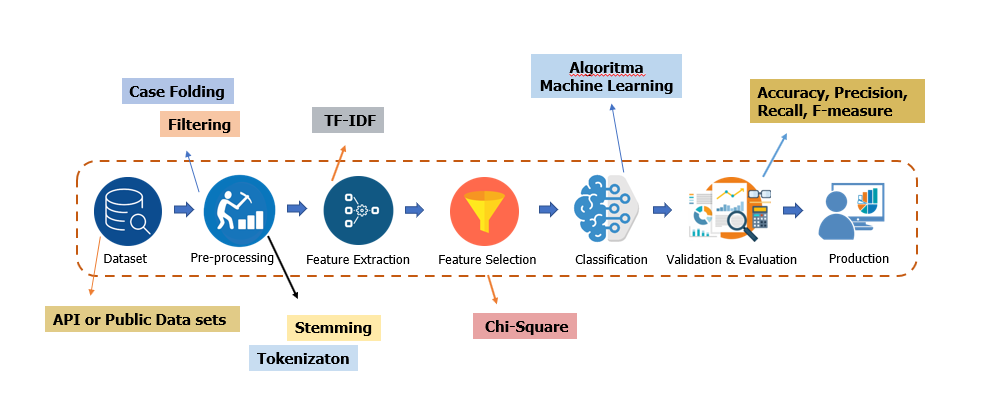

Langkah-langkah penyelesaian meliputi:
1. Data Acquisition
2. Text Pre-processing
   1. Case Folding
   2. Filtering
   3. Stopword
   4. Stemming
3. Feature Engineering
   1. Feature Extraction - BoW & TF IDF
   2. Feature Selection - Chi-Square
4. Modelling (Machine Learning)
5. Model Evaluation
6. Deployment


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Untuk mempermudah, simpan setiap objek agar dapat digunakan untuk pemodelan maupun deployment. Gunakan library Pickle
import pickle

%matplotlib inline

In [2]:
# Install library Sastrawi
!pip -q install sastrawi

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 01 Data Acquisition

Penjelasan Label 
* 0: Sentiment Negative 
* 1: Sentiment Positive 

In [17]:
# Download dataset
#!wget https://github.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/blob/master/dataset_tweet_sentiment_opini_film.csv

--2022-10-05 09:18:52--  https://github.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/blob/master/dataset_tweet_sentiment_opini_film.csv
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: 'dataset_tweet_sentiment_opini_film.csv.1'

     0K .......... .......... .......... .......... ..........  241K
    50K .......... .......... .......... .......... ..........  408K
   100K .......... .......... .......... .......... ..........  399K
   150K .......... .......... .......... .......... ..........  408K
   200K .......... .....                                        419K=0,6s

2022-10-05 09:18:53 (350 KB/s) - 'dataset_tweet_sentiment_opini_film.csv.1' saved [220173]



In [4]:
data = pd.read_csv('dataset_tweet_sentiment_opini_film.csv')
data

,Id,Sentiment,Text Tweet
0,1,negative,Jelek filmnya... apalagi si ernest gak mutu bg...
1,2,negative,Film king Arthur ini film paling jelek dari se...
2,3,negative,@beexkuanlin Sepanjang film gwa berkata kasar ...
3,4,negative,Ane ga suka fast and furious..menurutku kok je...
4,5,negative,"@baekhyun36 kan gua ga tau film nya, lu bilang..."
...,...,...,...
195,196,positive,Fargo juga adaptasi dari film yang cukup berha...
196,197,positive,637.000 waw ini sangat keren flm horor dng jum...
197,198,positive,@filmziarah film yang tenang dan menghanyutkan...
198,199,positive,Film yg amat menarik. Kisah cinta & kesetiaan ...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Id          200 non-null    int64 
 1   Sentiment   200 non-null    object
 2   Text Tweet  200 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB


In [6]:
# Mengubah Sentiment menjadi label (0 & 1) -> 0 : Negative, 1 : Positive
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data.Sentiment = le.fit_transform(data.Sentiment.values)

In [7]:
data.head()

,Id,Sentiment,Text Tweet
0,1,0,Jelek filmnya... apalagi si ernest gak mutu bg...
1,2,0,Film king Arthur ini film paling jelek dari se...
2,3,0,@beexkuanlin Sepanjang film gwa berkata kasar ...
3,4,0,Ane ga suka fast and furious..menurutku kok je...
4,5,0,"@baekhyun36 kan gua ga tau film nya, lu bilang..."


In [8]:
print('Total Jumlah Tweet:', data.shape[0], 'data\n')
print('terdiri dari (label):')
print('-- [0] Sentimen Negative\t:', data[data.Sentiment == 0].shape[0], 'data')
print('-- [1] Sentimen Positive\t:', data[data.Sentiment == 1].shape[0], 'data')

Total Jumlah Tweet: 200 data

terdiri dari (label):
-- [0] Sentimen Negative	: 100 data
-- [1] Sentimen Positive	: 100 data


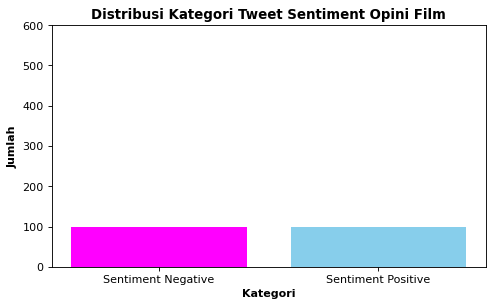

In [9]:
height = data['Sentiment'].value_counts()
labels = ('Sentiment Negative', 'Sentiment Positive')
y_pos = np.arange(len(labels))

plt.figure(figsize=(7,4), dpi=80)
plt.ylim(0,600)
plt.title('Distribusi Kategori Tweet Sentiment Opini Film', fontweight='bold')
plt.xlabel('Kategori', fontweight='bold')
plt.ylabel('Jumlah', fontweight='bold')
plt.bar(y_pos, height, color=['magenta', 'skyblue'])
plt.xticks(y_pos, labels)
plt.show()

# 02 Text Preprocessing

## Case Folding

In [10]:
import re

# Buat fungsi untuk langkah case folding
def casefolding(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()
  return text

In [11]:
raw_sample = data['Text Tweet'].iloc[5]
case_folding = casefolding(raw_sample)

print('Raw data\t: ', raw_sample)
print('Case folding\t: ', case_folding)

Raw data	:  tolong editingnya yg bagus ya. Saya sering kecewa dgn film indonesia. Ditunggu filmnya!!
Case folding	:  tolong editingnya yg bagus ya saya sering kecewa dgn film indonesia ditunggu filmnya


## Word Normalization

In [17]:
# Download corpus kumpulan slangwords
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv

--2022-10-05 09:25:00--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80969 (79K) [text/plain]
Saving to: 'key_norm.csv'

     0K .......... .......... .......... .......... .......... 63%  835K 0s
    50K .......... .......... .........                       100% 1,34M=0,08s

2022-10-05 09:25:00 (976 KB/s) - 'key_norm.csv' saved [80969/80969]



In [12]:
key_norm = pd.read_csv('key_norm.csv')
print(key_norm.head())

key_norm.shape

   _id      singkat       hasil
0    1         abis       habis
1    2       accent     tekanan
2    3       accept      terima
3    4     accident  kecelakaan
4    5  achievement    prestasi


(3720, 3)

In [13]:
def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

## Filtering (Stopword Removal)

In [14]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')

In [15]:
len(stopwords_ind)

758

In [16]:
# Lihat daftar stopword yang disediakan NLTK
stopwords_ind[:20]

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara']

In [17]:
# Buat fungsi untuk langkah stopword removal

more_stopword = ['ga','Ga','gak','bgt','ttg','sy','dgn','yg','utk','GW','gw','Tp','tp','krn','dr'] #Tambahkan kata lain dalam daftar stopword
stopwords_ind = stopwords_ind + more_stopword

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

In [18]:
raw_sample = data['Text Tweet'].iloc[20]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)

print('Raw data\t\t: ', raw_sample)
print('\nCase folding\t\t: ', case_folding)
print('\nStopword removal\t: ', stopword_removal)

Raw data		:  Film King Arthur itu tidak jelek namun juga tidak bagus. Biasa saja, cenderung mudah dilupakan.

Case folding		:  film king arthur itu tidak jelek namun juga tidak bagus biasa saja cenderung mudah dilupakan

Stopword removal	:  film king arthur jelek bagus cenderung mudah dilupakan


## Stemming

In [19]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [20]:
raw_sample = data['Text Tweet'].iloc[20]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)
text_stemming = stemming(stopword_removal)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)
print('Stemming\t\t: ', text_stemming)

Raw data		:  Film King Arthur itu tidak jelek namun juga tidak bagus. Biasa saja, cenderung mudah dilupakan.
Case folding		:  film king arthur itu tidak jelek namun juga tidak bagus biasa saja cenderung mudah dilupakan
Stopword removal	:  film king arthur jelek bagus cenderung mudah dilupakan
Stemming		:  film king arthur jelek bagus cenderung mudah lupa


## Text Preprocessing Pipeline

In [21]:
# Buat fungsi untuk menggabungkan seluruh langkah text preprocessing
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  return text

In [22]:
%%time
data['clean_teks'] = data['Text Tweet'].apply(text_preprocessing_process)

# Perhatikan waktu komputasi ketika proses text preprocessing

Wall time: 1min 36s


In [23]:
data

,Id,Sentiment,Text Tweet,clean_teks
0,1,0,Jelek filmnya... apalagi si ernest gak mutu bg...,jelek film si ernest mutu banget actingnya fil...
1,2,0,Film king Arthur ini film paling jelek dari se...,film king arthur film jelek cerita king arthur
2,3,0,@beexkuanlin Sepanjang film gwa berkata kasar ...,beexkuanlin film gwa kasar bapak
3,4,0,Ane ga suka fast and furious..menurutku kok je...,suka fast and furiousmenurutku jelek ya film
4,5,0,"@baekhyun36 kan gua ga tau film nya, lu bilang...",baekhyun tau film nya bilang perang perang per...
...,...,...,...,...
195,196,1,Fargo juga adaptasi dari film yang cukup berha...,fargo adaptasi film hasil season nya the best
196,197,1,637.000 waw ini sangat keren flm horor dng jum...,waw keren flm horor tonton gin prillybie danur...
197,198,1,@filmziarah film yang tenang dan menghanyutkan...,filmziarah film tenang hanyut salut mbah ponco...
198,199,1,Film yg amat menarik. Kisah cinta & kesetiaan ...,film tarik kisah cinta setia saji bikin kangen...


In [24]:
# Simpan data yang telah melalui text preprocessing agar kita tidak perlu menjalankan proses tersebut mulai awal (Opsional)
data.to_csv('clean_data.csv')

# 03 Feature Engineering

In [25]:
# Pisahkan kolom fitur dan target
X = data['clean_teks']
y = data['Sentiment']

In [26]:
X

0      jelek film si ernest mutu banget actingnya fil...
1         film king arthur film jelek cerita king arthur
2                       beexkuanlin film gwa kasar bapak
3           suka fast and furiousmenurutku jelek ya film
4      baekhyun tau film nya bilang perang perang per...
                             ...                        
195        fargo adaptasi film hasil season nya the best
196    waw keren flm horor tonton gin prillybie danur...
197    filmziarah film tenang hanyut salut mbah ponco...
198    film tarik kisah cinta setia saji bikin kangen...
199    nntn filmziarah film bagus kali menit tonton a...
Name: clean_teks, Length: 200, dtype: object

In [27]:
y

0      0
1      0
2      0
3      0
4      0
      ..
195    1
196    1
197    1
198    1
199    1
Name: Sentiment, Length: 200, dtype: int32

## Feature Extraction (Bag of Words & N-Gram)
Proses mengubah teks menjadi vektor menggunakan metode BoW

In [28]:
'''
Convert a collection of text documents to a matrix of token counts.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
'''
from sklearn.feature_extraction.text import CountVectorizer

# BoW - Unigram
bow = CountVectorizer(ngram_range=(1,1))
bow.fit(X)

CountVectorizer()

In [29]:
# Melihat jumlah fitur
print(len(bow.get_feature_names_out()))

768


In [30]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(bow.get_feature_names_out())

['abiss' 'acclaim' 'actingnya' 'adaptasi' 'adegan' 'aduh' 'aduk' 'agam'
 'agama' 'ah' 'air' 'ajaa' 'ajak' 'ajar' 'akan' 'akhrnya' 'aksi' 'akting'
 'aktor' 'aktris' 'ale' 'alf' 'alien' 'alitalit' 'alur' 'amat' 'ambigu'
 'amira' 'anak' 'and' 'andibowooo' 'aneh' 'angkat' 'anjak' 'anjlok' 'anya'
 'apresiasi' 'april' 'arah' 'arthur' 'artis' 'asih' 'asik' 'askmenfess'
 'asli' 'astagah' 'aurat' 'awisuryadi' 'baca' 'baekhyun' 'bagus'
 'baguskelompoknya' 'bagussss' 'bahagia' 'bahas' 'bahasa' 'baik' 'baja'
 'balap' 'balik' 'banding' 'bandung' 'bang' 'bangat' 'banget' 'bangetbuat'
 'bangetkalian' 'bangettt' 'bangga' 'banggafilmindonesia' 'bangsa' 'bangt'
 'banyak' 'bapak' 'bareng' 'baru' 'barusan' 'batal' 'batas' 'bawa' 'bawah'
 'bayang' 'bayar' 'bebas' 'beda' 'beexkuanlin' 'begadang' 'belah' 'belang'
 'benar' 'bener' 'benerbener' 'benerseru' 'bentar' 'berat' 'berbudget'
 'berekspektasi' 'berfikir' 'berkalikali' 'best' 'besut' 'betapa' 'bewe'
 'bg' 'bgni' 'bgussayangnya' 'bhineka' 'biasapemikiran

In [31]:
# Melihat matriks jumlah fitur
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_bow = bow.transform(X).toarray()
X_bow

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [32]:
data_bow = pd.DataFrame(X_bow, columns=bow.get_feature_names_out())
data_bow

,abiss,acclaim,actingnya,adaptasi,adegan,aduh,aduk,agam,agama,ah,...,wkwk,wonder,worth,ya,yah,yanskii,yaoi,youtube,yuk,ziarah
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
with open('bow_feature.pickle', 'wb') as output:
  pickle.dump(X_bow, output)

## Feature Extraction (TF-IDF & N-Gram)
Proses mengubah teks menjadi vector menggunakan metode TF-IDF

In [34]:
'''
Convert a collection of raw documents to a matrix of TF-IDF features
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
'''
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(X)

TfidfVectorizer()

In [35]:
# Melihat Jumlah Fitur
print(len(tf_idf.get_feature_names_out()))

768


In [36]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(tf_idf.get_feature_names_out())

['abiss' 'acclaim' 'actingnya' 'adaptasi' 'adegan' 'aduh' 'aduk' 'agam'
 'agama' 'ah' 'air' 'ajaa' 'ajak' 'ajar' 'akan' 'akhrnya' 'aksi' 'akting'
 'aktor' 'aktris' 'ale' 'alf' 'alien' 'alitalit' 'alur' 'amat' 'ambigu'
 'amira' 'anak' 'and' 'andibowooo' 'aneh' 'angkat' 'anjak' 'anjlok' 'anya'
 'apresiasi' 'april' 'arah' 'arthur' 'artis' 'asih' 'asik' 'askmenfess'
 'asli' 'astagah' 'aurat' 'awisuryadi' 'baca' 'baekhyun' 'bagus'
 'baguskelompoknya' 'bagussss' 'bahagia' 'bahas' 'bahasa' 'baik' 'baja'
 'balap' 'balik' 'banding' 'bandung' 'bang' 'bangat' 'banget' 'bangetbuat'
 'bangetkalian' 'bangettt' 'bangga' 'banggafilmindonesia' 'bangsa' 'bangt'
 'banyak' 'bapak' 'bareng' 'baru' 'barusan' 'batal' 'batas' 'bawa' 'bawah'
 'bayang' 'bayar' 'bebas' 'beda' 'beexkuanlin' 'begadang' 'belah' 'belang'
 'benar' 'bener' 'benerbener' 'benerseru' 'bentar' 'berat' 'berbudget'
 'berekspektasi' 'berfikir' 'berkalikali' 'best' 'besut' 'betapa' 'bewe'
 'bg' 'bgni' 'bgussayangnya' 'bhineka' 'biasapemikiran

In [37]:
# Melihat matriks jumlah token
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_tf_idf = tf_idf.transform(X).toarray()
X_tf_idf

array([[0.        , 0.        , 0.42687534, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [38]:
# Melihat matriks jumlah token menggunakan TF IDF, lihat perbedaannya dengan metode BoW
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,abiss,acclaim,actingnya,adaptasi,adegan,aduh,aduk,agam,agama,ah,...,wkwk,wonder,worth,ya,yah,yanskii,yaoi,youtube,yuk,ziarah
0,0.0,0.0,0.426875,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.319106,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.259967,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.000000,0.37323,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
196,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
197,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
198,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0


In [39]:
with open('tf_idf_feature.pickle', 'wb') as output:
  pickle.dump(X_tf_idf, output)

## Feature Selection (Chi Square)

In [40]:
# Mengubah nilai data tabular tf-idf menjadi array agar dapat dijalankan pada proses seleksi fitur
X = np.array(data_tf_idf)
y = np.array(y)

In [46]:
'''
Select features according to the k highest scores.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

Compute chi-squared stats between each non-negative feature and class.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html
'''

from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 

# Ten features with highest chi-squared statistics are selected 
chi2_features = SelectKBest(chi2, k=550) 
X_kbest_features = chi2_features.fit_transform(X, y) 
  
# Reduced features 
print('Original feature number:', X.shape[1]) 
print('Reduced feature number:', X_kbest_features.shape[1]) 

Original feature number: 768
Reduced feature number: 550


In [47]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
data_chi2

,nilai
0,0.247537
1,0.379005
2,0.426875
3,0.227127
4,0.597267
...,...
763,0.649226
764,0.259967
765,0.414480
766,0.355231


In [48]:
# Menampilkan fitur beserta nilainya
feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2

,nilai,fitur
0,0.247537,abiss
1,0.379005,acclaim
2,0.426875,actingnya
3,0.227127,adaptasi
4,0.597267,adegan
...,...,...
763,0.649226,yanskii
764,0.259967,yaoi
765,0.414480,youtube
766,0.355231,yuk


In [49]:
# Mengurutkan fitur terbaik
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
355,5.686051e+00,kecewa
320,5.428342e+00,jelek
366,4.928727e+00,keren
267,3.088979e+00,hambar
466,2.438656e+00,mummy
...,...,...
204,4.574890e-04,emang
625,3.870304e-04,selesai
265,3.397820e-04,habis
391,2.358735e-04,langsung


In [50]:
# Menampilkan mask pada feature yang diseleksi
# False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask = chi2_features.get_support()
mask

array([False,  True,  True, False,  True,  True,  True, False,  True,
       False,  True,  True, False, False, False, False, False, False,
        True,  True,  True, False,  True, False,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True, False,  True, False, False,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True, False,  True,
        True, False,  True,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True, False, False,  True,
       False, False, False, False,  True,  True,  True, False, False,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,

In [51]:
# Menampilkan fitur-fitur terpilih berdasarkan mask atau nilai tertinggi yang sudah dikalkulasi pada Chi-Square
new_feature = []

for bool, f in zip(mask, feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature

selected_feature

['acclaim',
 'actingnya',
 'adegan',
 'aduh',
 'aduk',
 'agama',
 'air',
 'ajaa',
 'aktor',
 'aktris',
 'ale',
 'alien',
 'alur',
 'amat',
 'anak',
 'and',
 'andibowooo',
 'aneh',
 'angkat',
 'anjak',
 'anjlok',
 'anya',
 'apresiasi',
 'april',
 'arthur',
 'artis',
 'asih',
 'asik',
 'askmenfess',
 'asli',
 'astagah',
 'awisuryadi',
 'bagus',
 'baguskelompoknya',
 'bagussss',
 'bahagia',
 'bahas',
 'bahasa',
 'baik',
 'balap',
 'banding',
 'bang',
 'bangat',
 'bangetbuat',
 'bangetkalian',
 'bangettt',
 'bangga',
 'banggafilmindonesia',
 'bangt',
 'bapak',
 'bareng',
 'baru',
 'barusan',
 'batal',
 'bawah',
 'beexkuanlin',
 'begadang',
 'belah',
 'benerbener',
 'benerseru',
 'bentar',
 'berat',
 'berekspektasi',
 'berfikir',
 'berkalikali',
 'best',
 'besut',
 'betapa',
 'bgni',
 'bgussayangnya',
 'bhineka',
 'biasapemikiran',
 'bilang',
 'bingittsss',
 'bingung',
 'biografi',
 'bkin',
 'black',
 'bloopernya',
 'bluray',
 'bngt',
 'bodoh',
 'bom',
 'bosan',
 'bosen',
 'bravo',
 'britne

In [52]:
# Cara melihat vocab yang dihasilkan oleh TF_IDF
# tf_idf.vocabulary_ 

kbest_feature = {} # Buat dictionary kosong

for (k,v) in tf_idf.vocabulary_.items():    # Iterasi untuk mengulangi vocab yang dihasilkan TF_IDF
  if k in selected_feature:                 # Cek apakah fitur termasuk k fitur yang diseleksi
    kbest_feature[k] = v                    # Jika iya, simpan fitur tersebut pada dictionary kosong diatas

In [53]:
kbest_feature

{'jelek': 320,
 'si': 642,
 'ernest': 214,
 'mutu': 468,
 'actingnya': 2,
 'sampah': 606,
 'king': 373,
 'arthur': 39,
 'beexkuanlin': 85,
 'gwa': 264,
 'kasar': 347,
 'bapak': 73,
 'and': 29,
 'furiousmenurutku': 236,
 'bilang': 109,
 'perang': 538,
 'tolong': 725,
 'editingnya': 198,
 'bagus': 50,
 'kecewa': 355,
 'indonesia': 297,
 'salah': 602,
 'aktor': 18,
 'dukung': 195,
 'nista': 492,
 'agama': 8,
 'tonton': 727,
 'parah': 521,
 'guys': 263,
 'dear': 174,
 'radityadika': 568,
 'sorry': 656,
 'say': 611,
 'this': 708,
 'themummy': 706,
 'memgecewakan': 442,
 'yah': 762,
 'berekspektasi': 96,
 'mesir': 447,
 'kuno': 388,
 'isi': 309,
 'kartini': 345,
 'critical': 163,
 'ale': 20,
 'anya': 35,
 'lemah': 403,
 'jaman': 317,
 'bodoh': 120,
 'ngomong': 484,
 'danur': 168,
 'singkat': 647,
 'biografi': 112,
 'bingung': 111,
 'bukuny': 134,
 'banding': 60,
 'anjlok': 34,
 'alien': 22,
 'ragu': 569,
 'satusatunya': 610,
 'rugi': 592,
 'baguskelompoknya': 51,
 'kasih': 348,
 'harga': 277

In [54]:
# Menampilkan fitur-fitur yang sudah diseleksi 
# Beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses machine learning

# Hanya k fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(X_kbest_features, columns=selected_feature)
data_selected_feature

,acclaim,actingnya,adegan,aduh,aduk,agama,air,ajaa,aktor,aktris,...,watch,waw,weird,wkwk,worth,yah,yanskii,youtube,yuk,ziarah
0,0.0,0.426875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.421283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
with open('kbest_feature.pickle', 'wb') as output:
  pickle.dump(kbest_feature, output)

# 04 Modelling (Machine Learning)

In [56]:
'''
Supervised learning in Sklearn
https://scikit-learn.org/stable/supervised_learning.html
'''
from sklearn.naive_bayes import MultinomialNB           # Pilih salah satu algoritma supervised learning. Contoh ini menggunakan algoritma Naive Bayes
from sklearn.model_selection import train_test_split    # Digunakan untuk memisahkan data uji dan data latih
from joblib import dump                                 # Digunakan untuk menyimpan model yang telah dilatih

In [57]:
# Proses memisahkan data uji dan data latih. Perbandingan 80% untuk data latih, 20% untuk data uji
# Random_state digunakan untuk internal random generator
# Gunakan fitur (X) hasil seleksi fitur

# Split arrays or matrices into random train and test subsets.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, y_train, y_test = train_test_split(X_kbest_features, y, test_size=0.2, random_state=40)

In [58]:
# Training the model
algorithm = MultinomialNB()               # Load algoritma pembelajaran
model = algorithm.fit(X_train, y_train)   # Fitkan (latih) algoritma pada data latih & label latih 

# Simpan model hasil traning
dump(model, filename='model_1.joblib')

['model_1.joblib']

In [59]:
# Gunakan model yang telah di latih untuk memprediksi label pada data uji
model_pred = model.predict(X_test)

# Tampilkan hasil prediksi label dari model
model_pred

array([0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1])

In [60]:
# Tampilkan label sebenarnya pada data uji (actual label)
y_test

array([0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1])

# 05 Model Evaluation

In [61]:
# Hitung jumlah data yang berhasil di prediksi model & jumlah data yang salah di prediksi
prediksi_benar = (model_pred == y_test).sum()
prediksi_salah = (model_pred != y_test).sum()

print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('Akurasi pengujian\t:', accuracy, '%')

Jumlah prediksi benar	: 37
Jumlah prediksi salah	: 3
Akurasi pengujian	: 92.5 %


In [62]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, model_pred)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[17  2]
 [ 1 20]]


In [63]:
from sklearn.metrics import classification_report

print('Classification report:\n', classification_report(y_test, model_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.92        19
           1       0.91      0.95      0.93        21

    accuracy                           0.93        40
   macro avg       0.93      0.92      0.92        40
weighted avg       0.93      0.93      0.92        40



In [64]:
# Cross Validation

from sklearn.model_selection import ShuffleSplit    # bisa pilih beberapa teknik cross validation
from sklearn.model_selection import cross_val_score # untuk mengetahui performa model pada cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=50)

cv_accuracy = (cross_val_score(model, X_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

Akurasi setiap split: [0.975 0.95  0.9   0.775 0.875 0.925 0.925 0.925 0.925 0.925] 

Rata-rata akurasi pada cross validation: 0.9100000000000001


# 06 Simple Deployment


In [65]:
from joblib import load

# load model
model = load('model_1.joblib')

# load vocabulary dari TF_idf
vocab = pickle.load(open('kbest_feature.pickle', 'rb'))

In [67]:
#@title Masukkan Teks Anda:
#input_text = "Bisa Bayar Di Tempat. Kacang mede/mente asli Wonogiri. Stok selalu baru dan fress bukan stok lama. Sedia. Mentah utuh120rb. Matang 135rbu. Chat/wa 08229808xxxx." #@param {type:"string"}
input_text = input("Masukkan contoh opini :")

pre_input_text = text_preprocessing_process(input_text)   # lakukan text pre processing pada text input

tf_idf_vec = TfidfVectorizer(vocabulary=set(vocab))       # definisikan TF_IDF

result = model.predict(tf_idf_vec.fit_transform([pre_input_text]))  # Lakukan prediksi

print('\nHasil Text Preprocessing :', pre_input_text)

if (result==0):
  tweet = 'Sentiment Negative'
else : 
  tweet = 'Sentiment Positive'

print('\nHasil prediksi', input_text, '\nadalah\n', tweet)

Masukkan contoh opini :jelek nih filmnya

Hasil Text Preprocessing : jelek nih film

Hasil prediksi jelek nih filmnya 
adalah
 Sentiment Negative


# 07 WordCloud

In [68]:
# Import Library WordCloud. WordCloud digunakan untuk melihat secara visual kata-kata yang paling sering muncul.
# Import Library cv2 untuk mengolah gambar menjadi masking WordCloud

import cv2
from wordcloud import WordCloud

In [69]:
# Download gambar masking
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/img/cloud.jpg

--2022-10-06 00:13:21--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/img/cloud.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34396 (34K) [image/jpeg]
Saving to: 'cloud.jpg.1'

     0K .......... .......... .......... ...                  100% 10,1M=0,003s

2022-10-06 00:13:21 (10,1 MB/s) - 'cloud.jpg.1' saved [34396/34396]



In [70]:
originalImage = cv2.imread('cloud.jpg')
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
(thresh, cloud_mask) = cv2.threshold(grayImage, 100, 255, cv2.THRESH_BINARY)

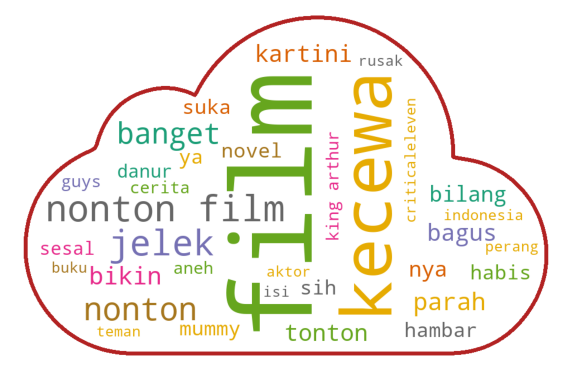

In [72]:
# WordCloud Label Sentiment Positive pada Tweet Opini Film

Negative = data[data.Sentiment == 0]
normal_string = []

for t in Negative.clean_teks:
  normal_string.append(t)

normal_string = pd.Series(normal_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(normal_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

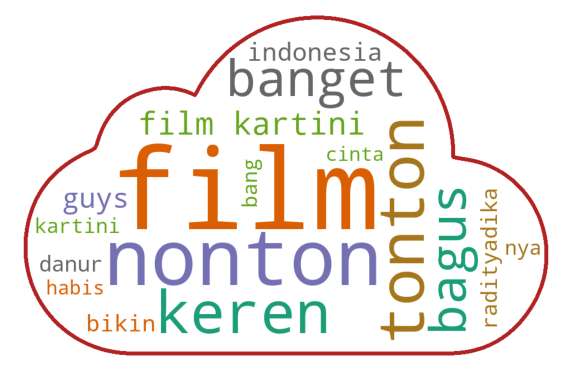

In [74]:
# WordCloud Label Sentiment Positive pada Tweet Opini Film

Positive = data[data.Sentiment == 1]
fraud_string = []

for t in Positive.clean_teks:
  fraud_string.append(t)

fraud_string = pd.Series(fraud_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(fraud_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()